Here, some exploratory techniques will be applied to the region-level time series to identify the network factors.

### Methods
- conditioning on networks using formula
- MEAN: averaging region time series with a network
- PCA: the first component of the PCA on the region time series
- UMAP: the first component of the UMAP on the region time series
- DOWHY: causal inference on the region time series

In [ ]:
# uncomment if formulae or dowhy are not installed.
# Alternatively, you can install them with pip install formulae dowhy

%conda install formulae dowhy

In [278]:
from python.acnets.pipeline import Parcellation
import pandas as pd
import numpy as np

from formulae import design_matrices

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP


In [279]:
atlas = 'dosenbach2010'
p = Parcellation(atlas)
DATA = p.fit_transform(None)

X = pd.DataFrame(DATA[0].T, index=p.labels_.index)
X.columns = [f't{c}' for c in X.columns]
X = X.join(p.labels_).drop(columns=list('xyz'))

In [129]:

timestep_term = '+'.join(X.columns).replace('+network', '|network')

d1 = design_matrices(f'({timestep_term})', X).group
d2 = design_matrices(f'({timestep_term})', X).group

# sns.heatmap(d1['t1|network'])
# plt.show()
# sns.heatmap(d1['t2|network'])

# X.groupby('network')['t1'].mean(), d1.mean(axis=0), d2.mean(axis=0)
d1['t1|network'].mean(), d1['t20|network'].mean(), d1['t1|network'].shape

(88.56784624936208, 88.52282564988197)

<AxesSubplot:xlabel='variable', ylabel='value'>

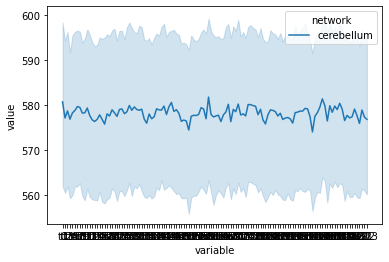

In [210]:
ts1 = X.reset_index().melt(id_vars=['region','network']).query('network == "cerebellum"')
sns.lineplot(data=ts1, x='variable', y='value', hue='network')

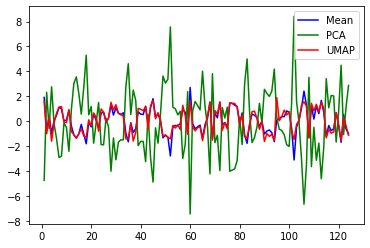

In [261]:
X_cerebellum = X.query('network == "cerebellum"').drop(columns='network').T

ts_mean = X_cerebellum.mean(axis=1).values
ts_pca = PCA(n_components='mle').fit_transform(X_cerebellum)
ts_umap = UMAP(n_components=1).fit_transform(X_cerebellum)

ts_mean = (ts_mean - ts_mean.mean()) / ts_mean.std()
ts_pca = (ts_pca - ts_pca.mean()) / ts_pca.std()
ts_umap = (ts_umap - ts_umap.mean()) / ts_umap.std()

sns.lineplot(y=ts_mean,x=range(1,125), color='blue', label='Mean')
sns.lineplot(y=ts_pca[:,0],x=range(1,125),color='green', label='PCA')
sns.lineplot(y=ts_umap[:,0],x=range(1,125),color='red', label='UMAP')
plt.legend()

In [ ]:
pca = PCA(n_components='mle')
pca.fit_transform(X_cerebellum)
pca.explained_variance_

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Causal estimate: -6.806707004689201
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treat

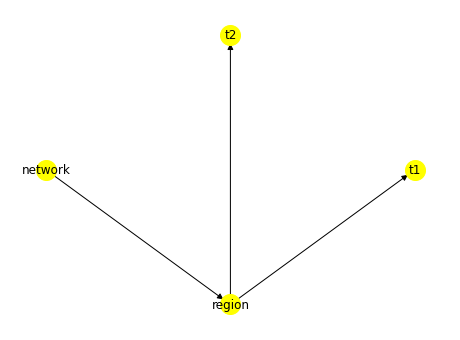

In [316]:
# I. Create a causal model from the data and given graph.

from dowhy import CausalModel
import dowhy.api

X_dowhy = X.copy()
X_dowhy['network'] = X_dowhy['network'].astype('category').cat.codes
X_dowhy = X_dowhy[['t1','t2','network']].reset_index()
# X_dowhy[['t1','network']].causal.do(
#     x='network',
#     outcome='t1',
#     variable_types={'t1':'c', 'network': 'd'})

model = CausalModel(
    data=X_dowhy,
    treatment='network',
    outcome=['t1','t2'],
    graph='digraph { network -> region;region-> t1; region -> t2}')
model.view_model()

# # Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# print(identified_estimand)

# # III. Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression')

print('Causal estimate:', estimate.value)

# # IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name='random_common_cause')

print('refuting results:', refute_results.refutation_result)